## Import main packages used in the code

In [1]:
import numpy as np
from scipy.integrate import quad, quad_vec
import scipy.integrate as integrate
from scipy.special import erf
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from classy import Class

## Set the initial conditions at redshift 20 to be those from the best fit Planck 2018
(and a few constants)

In [2]:
zci=20
G = 6.67430e-11
M_sun = 1.98847e30
Mpc_to_m = 3.08567758149e22

cosmo = Class()
cosmo.set({'omega_b':0.0223828,'Omega_m':0.3166,'theta_s_100':1.04090,'A_s':2.101549e-09,'n_s':0.9660499,'tau_reio':0.05430842})
cosmo.set({'output':'mPk,dTk','P_k_max_1/Mpc':15.0,'z_max_pk':1000,'z_pk': 950})
cosmo.compute()

H0_SI = 100. * cosmo.h() * 3.24077929e-20
rho_crit = 3 * H0_SI**2 / (8 * np.pi * G)* ((Mpc_to_m**3) / M_sun)

D_initial=cosmo.scale_independent_growth_factor(zci)
D_prime_initial=-(cosmo.scale_independent_growth_factor_f(zci))*(cosmo.scale_independent_growth_factor(zci))/(1+zci)
rho_initial = rho_crit * cosmo.h()**2 * cosmo.Omega_m() * (1 + zci)**3 
rho_Lambda = rho_crit * cosmo.h()**2 * (1. - cosmo.Omega_m())
initial_conditions = [D_initial, D_prime_initial,rho_initial]

set initial conditions for $\sigma(R,z_i)$ and compute its derivative with respect to R:

In [3]:
rs=np.arange(0.1,600,0.1)
sigmain=np.array([((cosmo.sigma(i, zci, h_units=True))/(cosmo.scale_independent_growth_factor(zci))) for i in rs])
# sigmain=np.array([((cosmo.sigma(i, zci, h_units=True))) for i in rs])

interpsigmain=interpolate.CubicSpline(rs,sigmain)
derinterpsigmain=interpsigmain.derivative()


def sigmazin(R):
    b=interpsigmain(R)
    return b
        
def dsigmadr(R):
    a=derinterpsigmain(R) 
    b=interpsigmain(R)
    return a/b

hardcodes the functions:

$\frac{df_{void}}{dr}\equiv \frac{df}{d \ln \sigma}\sigma_{,R}=\frac{df}{d\sigma}\frac{\sigma_{,R}}{\sigma}$

$\frac{df_{PS}}{dr}= \sqrt{\frac{2}{\pi}}\nu e^{-\frac{\nu^2}{2}}\frac{d\sigma}{\sigma dr}$

and their time derivative (without term -$\dot{D}/{D}$)

Void fraction is taken from Jennings et al. (2013):  
$f_{\rm{ln}\sigma}(\sigma)=2\sum_{j=1}^{\infty}e^{-(\frac{j\pi x)^2}{2}}j\pi x^2\sin\left(j \pi D\right)\;,$
where $D= \frac{|\delta_v^{\rm{lin}}|}{|\delta_v^{\rm{lin}}| + \delta_c^{\rm{lin}}}$ and $x= \frac{D}{|\delta_v^{\rm{lin}}|}\sigma $.

This can be approximated with a piece-wise function:

$ f_{\rm{ln}\sigma}= \sqrt{\frac{2}{\pi}}\frac{|\delta_v^{\rm{lin}}|}{\sigma} e^{-( \frac{\delta_v^{\rm{lin}}}{\sqrt{2}\sigma})^2} $ for $x\leq 0.276$   $\qquad$
$f_{\rm{ln}\sigma}(\sigma)=2\sum_{j=1}^{4}e^{-(\frac{j\pi x)^2}{2}}j\pi x^2\sin\left(j \pi D\right)\;,$ for $x>0.276$

In [4]:
#Note that sigma and R are not independent! I am just speeding up (since [(sigma,r)/(sigma)] is time independent)

def multip_func_void(R,sigma,deltac,deltav):
    
    capD = -deltav/(deltac - deltav)
    x = -sigma*capD/deltav
    nuv = -deltav/sigma
    df = np.where(x <= 0.276, 
                  np.sqrt(2/np.pi)*nuv*np.exp(-nuv**2/2), # if condition == True
                  np.sum(np.array([(2*np.exp(-(i*np.pi*x)**2/2)*i*np.pi*x**2*np.sin(i*np.pi*capD)) for i in [1,2,3,4]]), axis=0))
    return -df * dsigmadr(R)


#missing the -dot{D}/D factor 

def der_multip_func_void(R,sigma,deltac,deltav):

    capD=(-deltav)/(-deltav + deltac)
    x=(sigma*capD)/deltav
    nuv=-deltav/sigma
    
    df = np.where(x <= 0.276, 
                  np.sqrt(2/np.pi)*nuv*np.exp(-nuv**2/2)*(1-nuv**2),
                  np.sum(np.array([(-2+(np.pi*i*x)**2)*2*np.exp(-(i*np.pi*x)**2/2)*i*np.pi*x**2*np.sin(i*np.pi*capD)  for i in [1,2,3,4]]),axis=0))
    return -df * dsigmadr(R)

## Hardcode (part of) f'' = (following, missing the (Dot{D}/D)^2 ) + (-D''/D)(der_multip_func_PS)

def sec_der_multip_func_void(R,sigma,deltac,deltav):

    capD=(-deltav)/(-deltav + deltac)
    x=(sigma*capD)/deltav
    nuv=-deltav/(np.sqrt(2)*sigma)
    
    df = np.where(x <= 0.276, 
                  np.sqrt(2/np.pi)*nuv*np.exp(-nuv**2/2)*(2-5*nuv**2+nuv**4),
                  np.sum(np.array([(2-5*(np.pi*i*x)**2+(np.pi*i*x)**4)*2*np.exp(-(i*np.pi*x)**2/2)*i*np.pi*x**2*np.sin(i*np.pi*capD)  for i in [1,2,3,4]]),axis=0))
    return -df * dsigmadr(R)

                  
def multip_func_PS(R,sigma,delta):

    nu=delta/sigma
    df=np.sqrt(2/np.pi)*nu*np.exp(-nu**2/2)    
    return -df*dsigmadr(R)

# The one below misses the -dot{D}/D factor 
def der_multip_func_PS(R,sigma,delta):
    
    nu=delta/sigma
    df=np.sqrt(2/np.pi)*nu*np.exp(-nu**2/2)*(1-nu**2)
    return -df*dsigmadr(R)

## Hardcode (part of) f'' = (following, missing the (Dot{D}/D)^2 ) + (-D''/D)(der_multip_func_PS)

def sec_der_multip_func_PS(R,sigma,delta):
    nu=delta/sigma
    df=np.sqrt(2/np.pi)*nu*np.exp(-nu**2/2)*(2-5*nu**2+nu**4)
    return -df*dsigmadr(R)

### Field Equations to integrate:


(time derivatives $\dot{x}$ are converted in redshifts $x'$):

$\rho_{tot}' =\frac{3}{1+z}\rho_{tot}(1+ w_{tot})$


$D''= \frac{D'}{1+z}\left[1-\frac{3}{2}\frac{\rho_{tot}}{\rho_{tot}+\rho_\Lambda}\left(1+w_{tot}\right)  \right] + \frac{3}{2(1+z)^2}\frac{\rho_{tot}}{\rho_{tot}+\rho_\Lambda}D(1-f)
$

where we have defined
$f= f_{v} +f_{h}  \;,$ to be the fraction of objects in haloes and voids that haven't collapsed yet:

$f_v= f_{void}(\delta_v= -1) - f_{void}(\delta_v)= -2.71)$ 

$f_h= f_{PS}(\delta_c= 1.06) - f_{void}(\delta_v= 1.68)$ 


#### Numerical integration (main piece of code)  below:


In [5]:

#define the scales for the integrations in R. Change xbin for less or more precision
Rbin=0.05

z=np.arange(0,zci,0.01)
# flip required for the odeint in redshifts
zf=np.flip(z)

def solnum(scalec,scalev):
    rrangec=np.arange(scalec,71,Rbin)
    rrangev=np.arange(scalev,71,Rbin)
    sigmarzic=interpsigmain(rrangec)
    sigmarziv=interpsigmain(rrangev)
    def equations(y,z):
        D,D_prime,rho=y
        sigmaric= D*sigmarzic
        sigmariv= D*sigmarziv
#         computation of the total fractions of proto-haloes and proto-voids 
        integrandv1=multip_func_void(rrangev,sigmariv,1.68,-2.81) 
        integrandv2=multip_func_void(rrangev,sigmariv,1.68,-1)
        integrandh1=multip_func_PS(rrangec,sigmaric,1.68)
        integrandh2=multip_func_PS(rrangec,sigmaric,1.06)
        Fractionv1=integrate.simps(integrandv1,rrangev)
        Fractionv2=integrate.simps(integrandv2,rrangev)
        Fractionh1=integrate.simps(integrandh1,rrangec)
        Fractionh2=integrate.simps(integrandh2,rrangec)
        Fv= Fractionv2-Fractionv1
        Fh= Fractionh2-Fractionh1
        F= Fv+Fh
        Eic1= -5/3*rho*1.68/5.62*Fractionh1
        Eic2= -5/3*rho*1.06/1.77*Fractionh2
        Eiv1=5/3*rho*2.8*Fractionv1
        Eiv2=5/3*rho*1.28/1.7*Fractionv2
        EioverVhalo= Eic2 - Eic1
        EioverVvoid= Eiv2 - Eiv1
        EioverV = EioverVhalo + EioverVvoid
        
        #Number densities and calculation of dot{E_int}.
        
        #derivatives
    
        derFractionv1=integrate.simps(der_multip_func_void(rrangev,sigmariv,1.68,-2.81),rrangev)
        derFractionv2=integrate.simps(der_multip_func_void(rrangev,sigmariv,1.68,-1),rrangev)
        derFractionh1=integrate.simps(der_multip_func_PS(rrangec,sigmaric,1.68),rrangec)
        derFractionh2=integrate.simps(der_multip_func_PS(rrangec,sigmaric,1.06),rrangec)
        der_Eic1=-(5/3)*rho*(1.68/5.62)*derFractionh1
        der_Eic2=-(5/3)*rho*(1.06/1.77)*derFractionh2
        der_Eiv1=(5/3)*rho*(2.8)*derFractionv1
        der_Eiv2=(5/3)*rho*(1.28/1.7)*derFractionv2
        x= -D_prime/D*(der_Eic2-der_Eic1 + der_Eiv2 - der_Eiv1)
        
        wtot= (1+z)/(3*rho)*x/(1-EioverV/rho)
        
    #ODE's to be solved
        
        drho_dz=3/(1+z)*rho*(1+wtot)
        dD_prime_dz= D_prime/(1+z)*(1-3/2*rho/(rho+rho_Lambda)*(1+wtot))  + 3/(2*(1+z)**2)*rho/(rho_Lambda + rho)*(1-F)*D
        return [D_prime,dD_prime_dz,drho_dz]

    solution=odeint(equations,initial_conditions,zf)

    return solution

### A bunch of Cosmology stuff functions helpful for plotting:

In [6]:
#Cosmology Stuff

def numsol(scalec,scalev):
    system=solnum(scalec,scalev)
    return system

def D(scalec,scalev):
    d=numsol(scalec,scalev)[:,0]
    return d

def D_prime(scalec,scalev):
    d=numsol(scalec,scalev)[:,1]
    return d

def rho_tot(scalec,scalev):
    d=numsol(scalec,scalev)[:,2]
    return d

def Hubble(scale1,scale2):
    H=(((rho_tot(scale1,scale2))/(rho_crit) + rho_Lambda/(rho_crit))*100**2)**(1/2)
    return H

def Omegam(scalec,scalev):
    om=((rho_tot(scalec,scalev)/(rho_crit))*100**2)/(Hubble(scalec,scalev))**2
    return om


def s8(scale1,scale2):
    sigma8t=sigmazin(8)*D(scale1,scale2)
    return sigma8t


def fs8model(scale1,scale2):
    ft=-D_prime(scale1,scale2)/D(scale1,scale2)*(1+zf)
    sigma8t=sigmazin(8)*D(scale1,scale2)
    fs8t=ft*sigma8t
    return fs8t

### A few plots:

Example plot of the effect if only voids/clusters


Text(0, 0.5, ' $\\Delta H/H_{Lcdm}$')

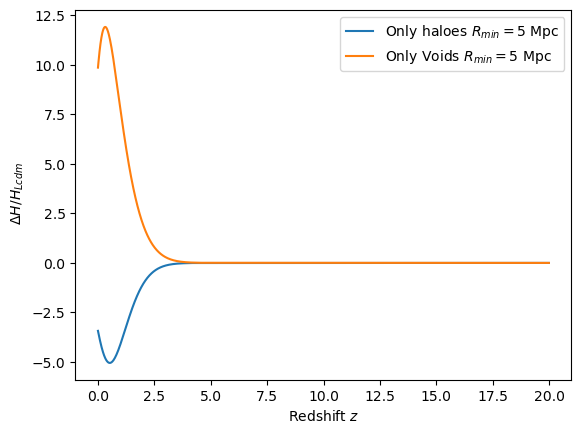

In [7]:
HubbleLCDM=Hubble(70,70)
print('Example plot of the effect if only voids/clusters')
plt.plot(zf,100*(Hubble(5,70)-HubbleLCDM)/HubbleLCDM, label='Only haloes $R_{min}=5$ Mpc')
plt.plot(zf,100*(Hubble(70,5)-HubbleLCDM)/HubbleLCDM, label='Only Voids $R_{min}= 5$ Mpc')
plt.legend()
plt.xlabel(r'Redshift $z$')
plt.ylabel(r' $\Delta H/H_{Lcdm}$')


$\Omega_m$ and $\sigma_8$ variations for the best fit of DESY5 and growth measurements


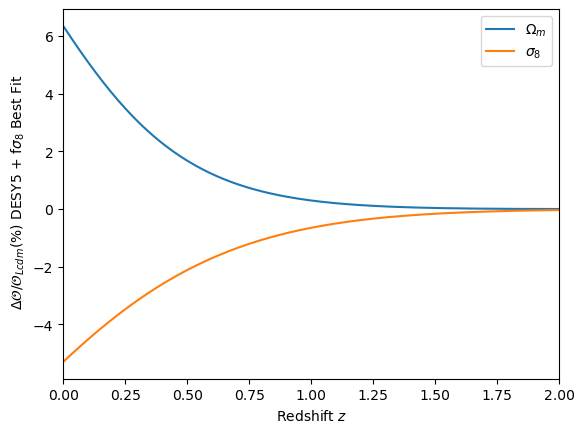

In [8]:
print('$\Omega_m$ and $\sigma_8$ variations for the best fit of DESY5 and growth measurements')
plt.plot(zf,100*(Omegam(10**0.76,10**0.82)-Omegam(70,70))/Omegam(70,70), label='$\Omega_m$')
plt.plot(zf,100*(s8(10**0.76,10**0.82)-s8(70,70))/s8(70,70), label='$\sigma_8$')
# plt.plot(zf,100*(DistanceM(10**0.76,10**0.82,zf)-DistanceM(70,70,zf))/DistanceM(70,70,zf), label='$\chi (z)$')

plt.legend()
plt.xlim(0,2)
# pl.grid()
plt.xlabel(r'Redshift $z$')
plt.ylabel(r' $\Delta \mathcal{O}/\mathcal{O}_{Lcdm} (\%)$ DESY5 + f$\sigma_8$ Best Fit')
plt.savefig('FracCP', dpi=300)
plt.show()

#### Plotting  f$\sigma_8$


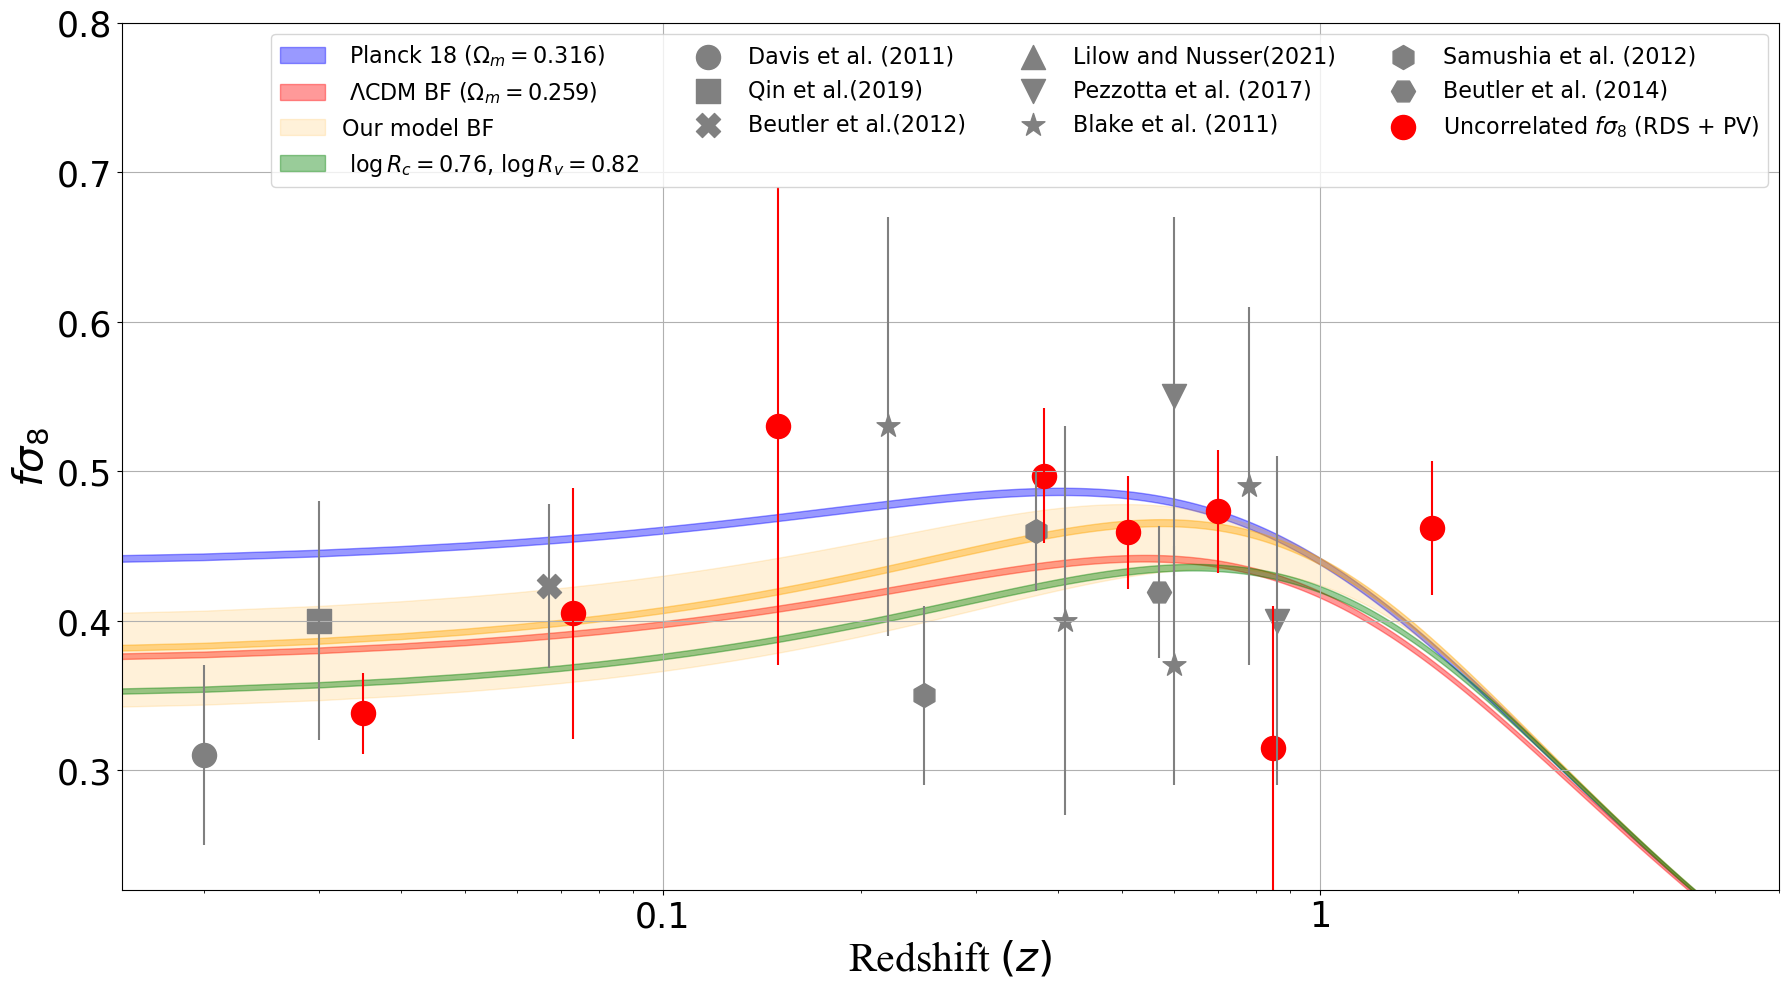

In [9]:
fs8lcdm=np.array([cosmo.scale_independent_f_sigma8(i) for i in zf])

def fs8model(scale1,scale2):
    ft=-D_prime(scale1,scale2)/D(scale1,scale2)*(1+zf)
    sigma8t=sigmazin(8)*D(scale1,scale2)
    fs8t=ft*sigma8t
    return fs8t

BFcosmo = Class()
BFcosmo.set({'omega_b':0.0223828,'Omega_m':0.259,'theta_s_100':1.04090,'A_s':2.101549e-09,'n_s':0.9660499,'tau_reio':0.05430842})
BFcosmo.set({'output':'mPk,dTk','P_k_max_1/Mpc':15.0,'z_max_pk':1000,'z_pk': 950})
BFcosmo.compute()
BFLCDM=np.array([BFcosmo.scale_independent_f_sigma8(i) for i in zf]) 


import matplotlib.pyplot as pl
fig, ax = pl.subplots(figsize=[18,10])

pl.fill_between(zf, (99.5/100)*fs8lcdm, (100.5/100)*fs8lcdm, label = r' Planck 18 ($\Omega_m = 0.316$)', color='blue', alpha=0.4)
pl.fill_between(zf, (99.5/100)*BFLCDM, (100.5/100)*BFLCDM, label = r' $\Lambda$CDM BF ($\Omega_m = 0.259$)', color='red', alpha=0.4)
pl.fill_between(zf, (99.5/100)*fs8model(10**0.76,10**1.13), (100.5/100)*fs8model(10**0.76,10**1.13), color='orange', alpha=0.4)
pl.fill_between(zf,fs8model(10**0.62,10**0.9), fs8model(10**0.87,10**1.38), label = r'Our model BF' , color='orange', alpha=0.15)
pl.fill_between(zf, (99.5/100)*fs8model(10**0.76,10**0.82), (100.5/100)*fs8model(10**0.76,10**0.82), label = r' $\log{R_{c}}=0.76$, $\log{R_{v}}=0.82$ ', color='green', alpha=0.4)
pl.ylim(0.22,0.8)
pl.xlim(0.015,5)
pl.xscale('log')
pl.scatter(0.02,0.31,marker="o",c='grey',s=300,label = 'Davis et al. (2011)')
pl.errorbar(0.02,0.31,yerr=0.06,fmt="grey")
pl.scatter(0.03,0.40,marker="s",c='grey',s=300,label = 'Qin et al.(2019)')
pl.errorbar(0.03,0.40,yerr=0.08,fmt="grey")
pl.scatter(0.067,0.423,marker="X",c='grey',s=300,label = 'Beutler et al.(2012)')
pl.errorbar(0.067,0.423,yerr=0.055,fmt="grey")
pl.scatter(0.013,0.367,marker="^",c='grey',s=300,label = 'Lilow and Nusser(2021)')
pl.errorbar(0.013,0.367,yerr=0.06,fmt="grey")
pl.scatter(0.6,0.55,marker="v",c='grey',s=300,label = 'Pezzotta et al. (2017)')
pl.errorbar(0.6,0.55,yerr=0.12,fmt="grey")
pl.scatter(0.86,0.4,marker="v",c='grey',s=300)
pl.errorbar(0.86,0.4,yerr=0.11,fmt="grey")


pl.scatter(0.22,0.53,marker="*",c='grey',s=300,label = 'Blake et al. (2011)')
pl.errorbar(0.22,0.53,yerr=0.14,fmt="grey")
pl.scatter(0.41,0.40,marker="*",c='grey',s=300)
pl.errorbar(0.41,0.40,yerr=0.13,fmt="grey")
pl.scatter(0.60,0.37,marker="*",c='grey',s=300)
pl.errorbar(0.60,0.37,yerr=0.08,fmt="grey")
pl.scatter(0.78,0.49,marker="*",c='grey',s=300)
pl.errorbar(0.78,0.49,yerr=0.12,fmt="grey")
pl.scatter(0.25,0.35,marker="h",c='grey',s=300,label = 'Samushia et al. (2012)')
pl.errorbar(0.25,0.35,yerr=0.06,fmt="grey")
pl.scatter(0.37,0.46,marker="h",c='grey',s=300)
pl.errorbar(0.37,0.46,yerr=0.04,fmt="grey")
pl.scatter(0.57,0.419,marker="H",c='grey',s=300,label = 'Beutler et al. (2014)')
pl.errorbar(0.57,0.419,yerr=0.044,fmt="grey")

#SDSS IV measurements
zeff=np.array([0.035,0.073,0.15,0.38,0.51,0.7,0.85,1.48])
measurements=np.array([0.338,0.405,0.53,0.497,0.459,0.473,0.315,0.462])
errors=np.array([0.027,0.084,0.16,0.045,0.038,0.041,0.095,0.045])

pl.scatter(zeff,measurements,marker="o",c='red',s=300,linestyle='None',label='Uncorrelated $f\sigma_8$ (RDS + PV)')
pl.errorbar(zeff,measurements,yerr=errors,fmt="red",linestyle='None')
pl.legend(loc='upper right',ncol=4,fontsize=16)
pl.xticks([10**-1,10**0],[0.1,1])
pl.xticks(fontsize=25)
pl.yticks(fontsize=25)
pl.grid()
pl.xlabel(r'Redshift $(z)$',fontname='Times New Roman',size=30)
pl.ylabel(r'$f \sigma_8$',fontname='Times New Roman',size=30)
pl.tight_layout()

pl.savefig("fs8_improv.png")
pl.show()